**2. Напишите, какие вы знаете способы борьбы с несбалансированными классами и почему с
ними нужно бороться, какие метрики вы будете использовать при оценке результатов. На
примере датасета https://www.kaggle.com/mlg-ulb/creditcardfraud продемонстрируйте, как
применять описанные вами методы и как они сказываются на результатах работы
алгоритмов классификации.**

Задача называется **несбалансированной**, если объектов одного класса существенно меньше, чем объектов остальных классов. Например, задача бинарной классификации называется несбалансированной, если объектов одного из двух классов менее 10%. 
    
В сильно несбалансированных выборках классификаторы могут настраиватся на объекты мажоритарного класса (когда высокую точность классификатора можно получить, не выделяя объекты миноритарного класса), в то время как во многих задачах, включая задачу обнаружения мошеннических транзакций, интерес представляют объекты миноритарного класса (мошеннические транзакции).

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
%matplotlib inline


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report


from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data.isnull().sum().max()

0

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Распределение классов

In [9]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

0 - нормальные транзакции 

1 - мошеннические транзакции

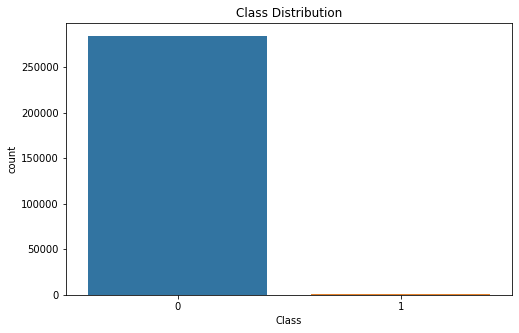

In [10]:
plt.figure(figsize = (8, 5))
plt.title('Class Distribution')
sns.countplot('Class', data=data)
plt.show()

In [11]:
normal_transaction = data[data.Class==0]
fraud_transaction = data[data.Class==1]

In [12]:
perc_normal_transaction = len(normal_transaction) / (len(normal_transaction) + len(fraud_transaction))
perc_fraud_transaction = len(fraud_transaction) / (len(normal_transaction) + len(fraud_transaction))

In [13]:
print('Number of normal transaction:', len(normal_transaction))
print('Percent of normal transaction:', round(perc_normal_transaction * 100, 3))
print('Number of fraud transaction:', len(fraud_transaction))
print('Percent of fraud transaction:', round(perc_fraud_transaction * 100, 3))

Number of normal transaction: 284315
Percent of normal transaction: 99.827
Number of fraud transaction: 492
Percent of fraud transaction: 0.173


Приблизительно в 0.17% случаев транзацакзции являются мошенническими, а остальные нормальными.

**Нормализуем данные в столбце 'Amount'**

In [18]:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(['Time'], axis=1, inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### Почему нужно бороться с дисбалансом классов
Основная проблема, связанная с несбалансированными выборками, состоит в том, что классификаторы минимизируют число неправильных ответов и никак не учитывают цены ошибок. Может возникнуть ситуация, когда выгоднее отнести все объекты к мажоритарному классу, не пытаясь как-то выделить объекты миноритарного класса. Другими словами, при работе с несбалансированными выборками классификаторы получаются очень плохие с точки зрения точности или полноты.

Ниже показан пример, где используется метрика accuracy для оценки точности алгоритма классификации. Воспользуемся алгоритмом DummyClassifier, который классифицирует по простому правилу - использует мажоритарный класс для классификации всех данных. В случае дисбаланса классов, все объекты будут отнесены к мажоритарному (нормальные транзакции), причем точность классификации будет очень высокой. Но мы будем классифицировать все объекты к классу 0, что неправильно, поскольку в таком случае мы упустим все мошеннические транзакции и отнесем их к нормальным. 

In [87]:
X_dummy = data.iloc[:, :-1]
y_dummy = data.Class

In [88]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy, y_dummy,
                                                                            test_size=0.3, random_state=10)

In [104]:
dummy = DummyClassifier(strategy="constant", constant=[0], random_state=0)
dummy.fit(X_train_dummy, y_train_dummy)

DummyClassifier(constant=[0], random_state=0, strategy='constant')

In [105]:
dummpy_pred = dummy.predict(X_test_dummy)

In [106]:
accuracy_score(y_test_dummy, dummpy_pred)

0.9983497770443454

In [107]:
pd.DataFrame(dummpy_pred)[0].value_counts()

0    85443
Name: 0, dtype: int64

In [108]:
print(classification_report(y_test_dummy, dummpy_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85302
           1       0.00      0.00      0.00       141

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



# Выбор метрики качества модели

Метриках качества классификации позволяют учитывать разные цены ошибок. Удобно классифицировать различные случаи, как соотносятся между собой результат работы алгоритма и истинный ответ, с помощью матрицы ошибок. Допустим, что у нас есть два класса и алгоритм, предсказывающий принадлежность каждого объекта одному из классов, тогда матрица ошибок классификации будет выглядеть следующим образом:
<img src="https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg" width="300" height="300">

Здесь — "predicted" это ответ алгоритма на объекте, а "actual" — истинная метка класса на этом объекте. Таким образом, ошибки классификации бывают двух видов: False Negative (FN) и False Positive (FP).

Доля правильных ответов **(accuracy)**:
<img src="https://media.geeksforgeeks.org/wp-content/uploads/Confusion_Matrix2_2.png" width="250" height="250">
Эта метрика бесполезна в задачах с несбалансированными классами, поскольку если алгоритм будет предсказывать всегда метку мажоритарного класса, то accuracy будет по прежнему очень высоким, но при этом наша модель совершенно не бдует обладать никакой предсказательной силой. Преодолеть это поможет переход с общей для всех классов метрики к отдельным показателям качества классов.

**Precision** можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а **recall** показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.
<img src="https://miro.medium.com/max/1068/1*EXa-_699fntpUoRjZeqAFQ.jpeg" width="400" height="400">

Именно введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов. Плюс precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок.


Обычно при оптимизации гиперпараметров алгоритма (например, в случае перебора по сетке GridSearchCV ) используется одна метрика, улучшение которой мы и ожидаем увидеть на тестовой выборке.
Существует несколько различных способов объединить precision и recall в агрегированный критерий качества. **F-мера** (в общем случае ) — среднее гармоническое precision и recall. F-мера достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

В нашей задаче в первую очередь нам будет интересен показатель Recall, поскольку эта метрика поможет нам отловить большинство мошеннических транзакций, т.е. нам нужно максимизировать этот показатель. Из-за дисбаланса классов, многие наблюдения могут быть предсказаны как False Negative (FN), т.е. предсказывается нормальная транзакция в то время как она на самом деле является мошеннической (ложный пропуск). Очевидно что попытка увеличить показатель Recall приводит к снижению показателя Precision (точность). Однако в нашем случае, если мы предсказываем что транзакция является мошеннической, а она оказывается не таковой, то цена этого будет ниже, чем цена если мы предскажем что транзакция является нормальной (ложное срабатывание - FP), а на самом деле она мошенническая. Но и сильно снижать Precision все таки не желательно, поскольку много нормальных транзакций будет детектироваться как мошеннические.

**Вспомогательные функции для обработки данных и построения графиков.**

Еще одна проблема, с которой можно столкнуться при работе с несбалансированными выборками, заключается в том, что при проведении кросс-валидации исходная выборка разбивается на k блоков примерно одинаковой длины. При этом, если выборка несбалансированная, может получиться ситуация, что в некоторые блоки объекты какого-то класса не попадут вообще. Такая ситуация крайне неприятна: при обучении на этом блоке получается классификатор, который никогда не видел один из классов.
Чтобы с этим бороться необходимо использовать стратификацию, то есть делать так,чтобы распределение классов в каждом блоке примерно совпадало с распределением классов в исходной выборке. В этом случае будет гарантироваться, что бъекты каждого из классов будут представлены в каждом из блоков разбиения. 

Для разбиения данные  будем использовать StratifiedKFold, чтобы пропорции классов в каждом блоке в точности соответствовали пропорциям классов в исходном наборе данных.

In [26]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 10)

In [27]:
def data_preparation(data):
    X = np.array(data.drop(columns='Class'))
    y = np.array(data.Class)

    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

### confusion matrix plot

In [28]:
def conf_matrix_plot(cnf_matrix):
    fig, ax = plt.subplots(figsize=(6,4))
    sns.set(font_scale=1.4)
    sns.heatmap(cnf_matrix, cmap="Blues", annot=True, annot_kws={"size": 16})
    plt.title('Confusion_matrix')
    plt.xlabel('Predicted_class')
    plt.ylabel('Real class')
    plt.show()

### undersampling

In [29]:
def undersample(X, y, n):
    data = pd.concat([pd.DataFrame(X), pd.DataFrame({'Class':y})], axis=1)
    
    normal_transaction = data[data.Class==0]
    fraud_transaction = data[data.Class==1]
    
    normal_transaction_undersample = resample(normal_transaction, replace=False, 
                                              n_samples=(len(fraud_transaction)*n), random_state=10)
    undersample_data = pd.concat([normal_transaction_undersample, fraud_transaction])
    
    print(undersample_data.Class.value_counts())
    
    X_train = undersample_data.drop(columns='Class')
    y_train = undersample_data.Class
    
    return X_train, y_train

### oversampling

In [30]:
def oversample(X, y, n):
    data = pd.concat([pd.DataFrame(X), pd.DataFrame({'Class':y})], axis=1)
    
    normal_transaction = data[data.Class==0]
    fraud_transaction = data[data.Class==1]
    
    fraud_transaction_oversample = resample(fraud_transaction, replace=True, 
                                            n_samples=(len(normal_transaction)*n), random_state=10)
    oversample_data = pd.concat([normal_transaction, fraud_transaction_oversample])
    
    print(oversample_data.Class.value_counts())
    
    X_train = oversample_data.drop(columns='Class')
    y_train = oversample_data.Class
    
    return X_train, y_train

Многие алгоритмы бинарной классификации устроены следующим образом: сначала вычисляется некоторое вещественное число, которое сравнивается с порогом. Часто бывает необходимо оценить качество именно оценки принадлежности, а порог выбирается позже из соображений на recall или precision.  

Первый способ оценки принадлежности классу основан на использовании **PR-кривой**. По оси X откладывается recall, а по оси Y — precision. Каждой точке на этой кривой будет соответствовать классификатор с некоторым значением порога. Следует отметить, что начинается PR-кривая всегда из точки (0,0), а заканчивается точной (1,r), где r — доля объектов класса 1. В случае идеального классификатора, то есть если существует такой порог, что и precision, и recall равны 100%, кривая будет проходить через точку (1,1). Таким образом, чем ближе кривая пройдет к этой точке, тем лучше оценки. Площадь под этой кривой может быть хорошей мерой качества оценок принадлежности к классу 1. Такая метрика называется AUC–PRC, или площадь под PR-кривой.

Второй способ измерить качество оценок принадлежности к классу 1 — **ROC-кривая**, которая строится в осях False Positive Rate (ось X) и True Positive Rate (ось Y). ROC-кривая строится аналогично PR-кривой: постепенно рассматриваются случаи различных значений порогов и отмечаются точки на графике. Кривая стартует с точки (0,0) и приходит в точку (1,1). При этом, если существует идеальный классификатор, кривая должна пройти через точку (0,1) (мы хотим максимизировать TPR и минимизровать FPR). Чем ближе кривая к этой точке, тем лучше будут оценки, а площадь под кривой будет характеризовать качество оценок принадлежности к первому классу. Такая метрика называется AUC–ROC, или площадь под ROC-кривой. Также считается что этот критерий является устойчивым к несбалансированным классам.

### PR-curve

In [31]:
def pr_curve(recall, precision):
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall curve')
    plt.show()

### ROC-curve

In [32]:
def auc_roc_curve(fpr, tpr):
    plt.title('Receiver Operating Characteristic')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Методы борьбы с несбалансированными данными

1.Собрать больше данных (если есть возможность);

2.Использовать сэмплирование исходных данных: oversampling/undersampling - брать больше объектов миноритарного класса, и меньше - мажоритарного класса;

3.SMOTE - сгенерировать синтетические данные, похожие на объекты миноритарного класса;

4.Использовать метрики не чувствительные к дисбалансу классов (F1, Precision);

5.Подбор алгоритма менее чувствительного к дисбалансу классов, например Random Forest;

6.Оптимизировать гиперпараметры алгоритма (например, перебором по сетке GridSearchCV), использовать кросс-валидацию (желательно StratifiedKFold).

In [34]:
X_train, X_test, y_train, y_test = data_preparation(data)

# Logistic Regression

### Со стандартными гиперпараметрами

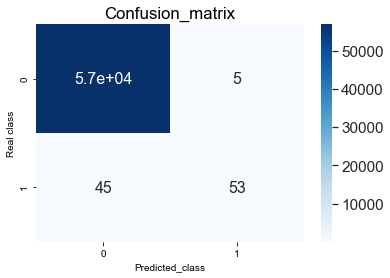

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.54      0.68        98

    accuracy                           1.00     56961
   macro avg       0.96      0.77      0.84     56961
weighted avg       1.00      1.00      1.00     56961



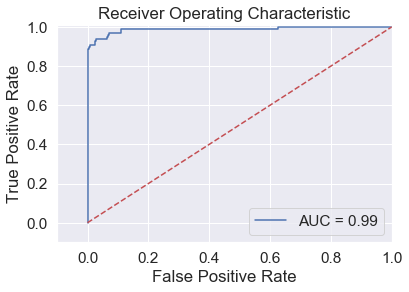

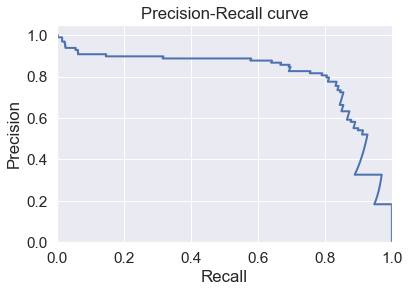

In [35]:
lr_wh = LogisticRegression()
lr_wh.fit(X_train, y_train)

pred_lr_wh = lr_wh.predict(X_test)
score_lr_wh = lr_wh.decision_function(X_test)

cm_lr_wh = confusion_matrix(y_test, pred_lr_wh)
conf_matrix_plot(cm_lr_wh)

print(classification_report(y_test, pred_lr_wh))

fpr, tpr, thresholds = roc_curve(y_test, score_lr_wh)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, score_lr_wh)
pr_curve(precision, recall)

In [36]:
lr_wh.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Подбор гиперпараметров по сетке (Grid Search CV) для оптимизации показателя Recall

In [37]:
param_grid = {
            'penalty' : ['l1','l2'], 
            'class_weight' : ['balanced', None], 
            'C' : [0.01, 0.1, 1, 10, 100]
            }

lr = LogisticRegression(solver='saga', random_state=27)
gs_lr = GridSearchCV(lr, param_grid, scoring='recall', cv=skf, verbose = 1, n_jobs = -1)
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=27, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [39]:
gs_lr.best_params_

{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}

In [40]:
gs_lr.best_score_

0.9137617656604998

### Модель с лучшими гиперпараметрами

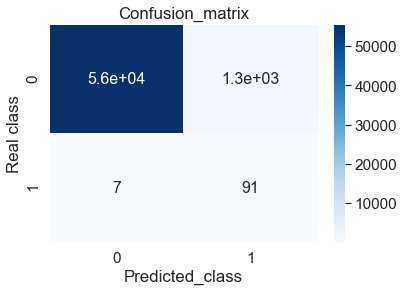

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.93      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961



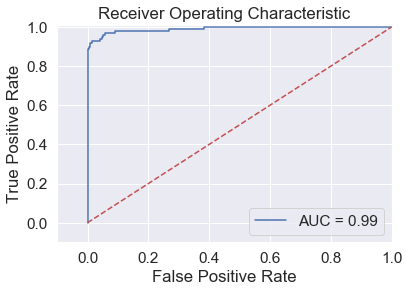

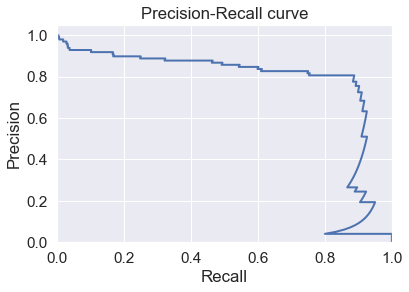

In [41]:
lr_best = gs_lr.best_estimator_
lr_best.fit(X_train, y_train)

pred_lr = lr_best.predict(X_test)
score_lr = lr_best.decision_function(X_test)

cm_lr = confusion_matrix(y_test, pred_lr)
conf_matrix_plot(cm_lr)

print(classification_report(y_test, pred_lr))

fpr, tpr, thresholds = roc_curve(y_test, score_lr)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, score_lr)
pr_curve(precision, recall)

Подбор гиперпараметров модели позволил значительно увеличить показатель recall (с 0.54 до 0.93) для мошеннических транзакций, однако уменьшил показатели, значительно - для precision и f1-score, и немного для accuracy. То есть модель стала теперь довольно часто относить нормальные транзакции к мошенническим. Но потери при отнесении нормальной транзакции к мошеннической будут меньше, чем в случае когда мы упустим мошенническую транзакцию и отнесем её к нормальной. В этом смысле полученная модель является лучше предыдущей. 

### Undersampling (logistic regression)

In [42]:
X_train_und, y_train_und = undersample(X_train, y_train, 1)

1    394
0    394
Name: Class, dtype: int64


In [43]:
lr = LogisticRegression(solver='saga', random_state=27)
gs_lr_und = GridSearchCV(lr, param_grid, scoring='recall', cv=skf, verbose = 1, n_jobs = -1)
gs_lr_und.fit(X_train_und, y_train_und)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=27, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [44]:
gs_lr_und.best_score_

0.911067835118468

In [45]:
gs_lr_und.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

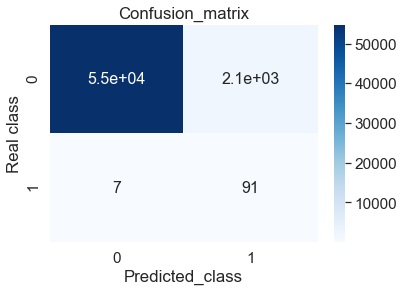

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.93      0.08        98

    accuracy                           0.96     56961
   macro avg       0.52      0.95      0.53     56961
weighted avg       1.00      0.96      0.98     56961



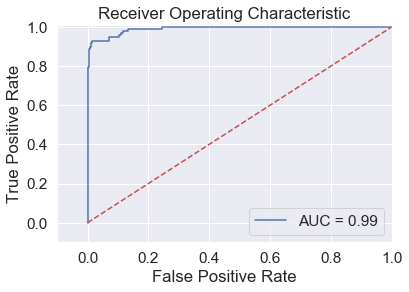

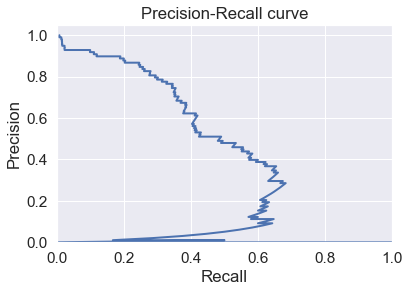

In [46]:
lr_best_und = gs_lr_und.best_estimator_
lr_best_und.fit(X_train_und, y_train_und)

pred_lr_und = lr_best_und.predict(X_test)
score_lr_und = lr_best_und.decision_function(X_test)

cm_lr_und = confusion_matrix(y_test, pred_lr_und)
conf_matrix_plot(cm_lr_und)

print(classification_report(y_test, pred_lr_und))

fpr, tpr, thresholds = roc_curve(y_test, score_lr_und)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, score_lr_und)
pr_curve(precision, recall)

Модель после сэмплирования мажоритарного класса немного ухудшила показатели precision и f1-score, показатель recall остался прежним. Она стала больше давать ложных положительных показаний - относить больше нормальных транзакций к мошенническим.

### Oversampling (logistic regression)

In [47]:
X_train_over, y_train_over = oversample(X_train, y_train, 1)

1    227452
0    227452
Name: Class, dtype: int64


In [48]:
lr = LogisticRegression(solver='saga', random_state=27)
gs_lr_over = GridSearchCV(lr, param_grid, scoring='recall', cv=skf, verbose = 1, n_jobs = -1)
gs_lr_over.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=27, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [49]:
gs_lr_over.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}

In [50]:
gs_lr_over.best_score_

0.9216406173969733

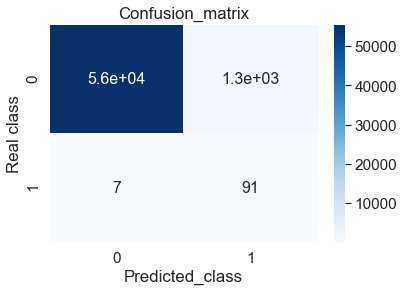

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.93      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961



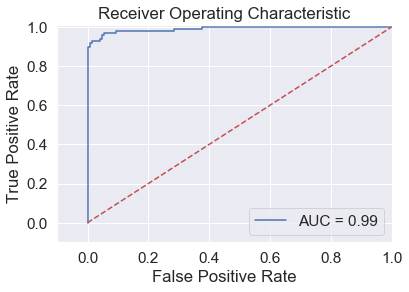

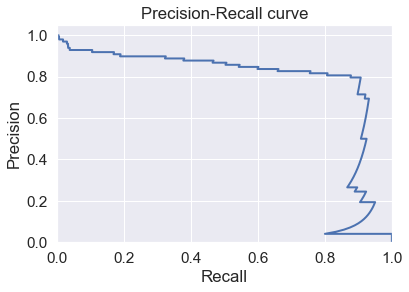

In [51]:
lr_best_over = gs_lr_over.best_estimator_
lr_best_over.fit(X_train_over, y_train_over)

pred_lr_over = lr_best_over.predict(X_test)
score_lr_over = lr_best_over.decision_function(X_test)

cm_lr_over = confusion_matrix(y_test, pred_lr_over)
conf_matrix_plot(cm_lr_over)

print(classification_report(y_test, pred_lr_over))

fpr, tpr, thresholds = roc_curve(y_test, score_lr_over)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, score_lr_over)
pr_curve(precision, recall)

Показатели precision, recall и f1-score аналогичны показателям полученным при обучении модели с настроенными гиперпараметрами без сэмплирования классов.

### SMOTE (logistic regression)

In [52]:
smote = SMOTE(random_state=27)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

In [53]:
print(len(X_train_smote), len(y_train_smote))

454904 454904


In [54]:
lr = LogisticRegression(solver='saga', random_state=27)
gs_lr_smote = GridSearchCV(lr, param_grid, scoring='recall', cv=skf, verbose = 1, n_jobs = -1)
gs_lr_smote.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=27, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [55]:
gs_lr_smote.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}

In [56]:
gs_lr_smote.best_score_

0.9153315848691108

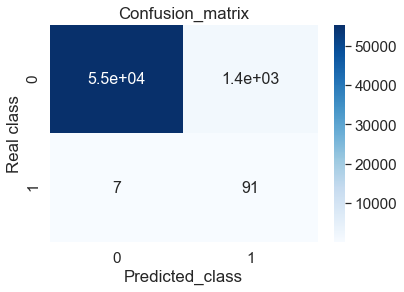

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.97      0.99     56961



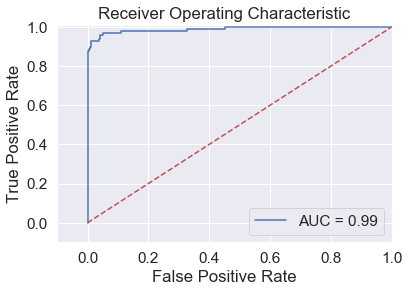

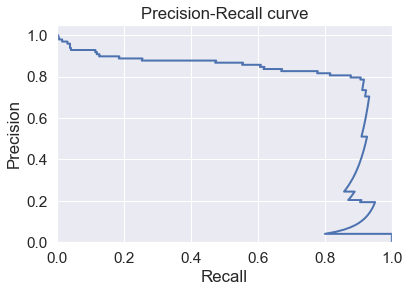

In [57]:
lr_best_smote = gs_lr_smote.best_estimator_
lr_best_smote.fit(X_train_smote, y_train_smote)

pred_lr_smote = lr_best_smote.predict(X_test)
score_lr_smote = lr_best_smote.decision_function(X_test)

cm_lr_smote = confusion_matrix(y_test, pred_lr_smote)
conf_matrix_plot(cm_lr_smote)

print(classification_report(y_test, pred_lr_smote))

fpr, tpr, thresholds = roc_curve(y_test, score_lr_smote)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, score_lr_smote)
pr_curve(precision, recall)

Показатели качества модели, полученные после генерации синтетических данных миноритарного класса, практически аналогичны показателям что и в случае сэплирования миноритарного класса (oversampling), и случая исходной несбалансированной выборки, за ичсклюючением показателя f1-score, он уменьшился на 0.01.

### Сравнение PR- и ROC-кривых для моделей логистической регрессии

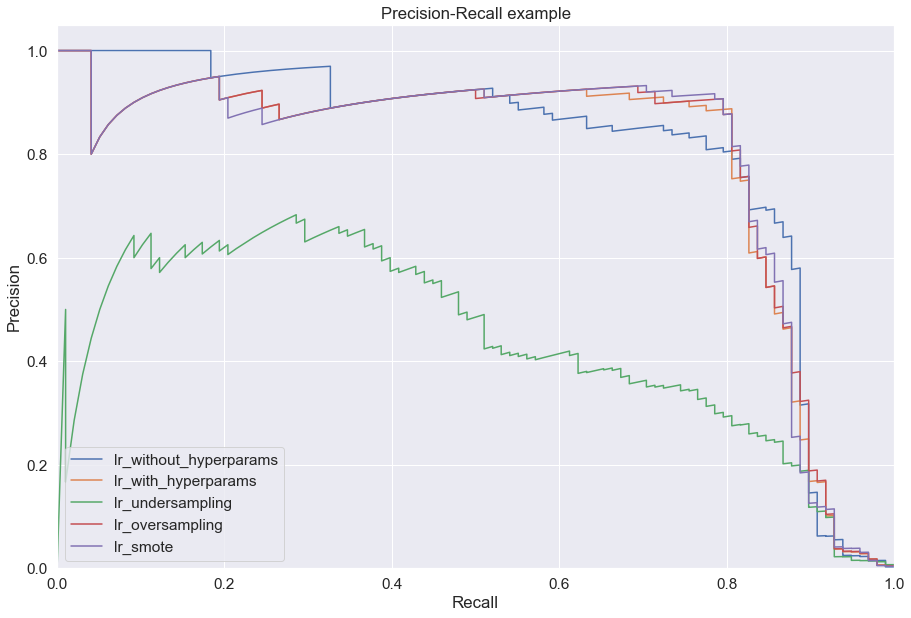

In [58]:
precision, recall, thresholds = precision_recall_curve(y_test, score_lr_wh)
precision1, recall1, thresholds1 = precision_recall_curve(y_test, score_lr)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, score_lr_und)
precision3, recall3, thresholds3 = precision_recall_curve(y_test, score_lr_over)
precision4, recall4, thresholds4 = precision_recall_curve(y_test, score_lr_smote)

plt.figure(figsize=(15,10))

plt.plot(recall, precision, label='lr_without_hyperparams')
plt.plot(recall1, precision1, label='lr_with_hyperparams')
plt.plot(recall2, precision2, label='lr_undersampling')
plt.plot(recall3, precision3, label='lr_oversampling')
plt.plot(recall4, precision4, label='lr_smote')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend(loc="lower left")

plt.show()

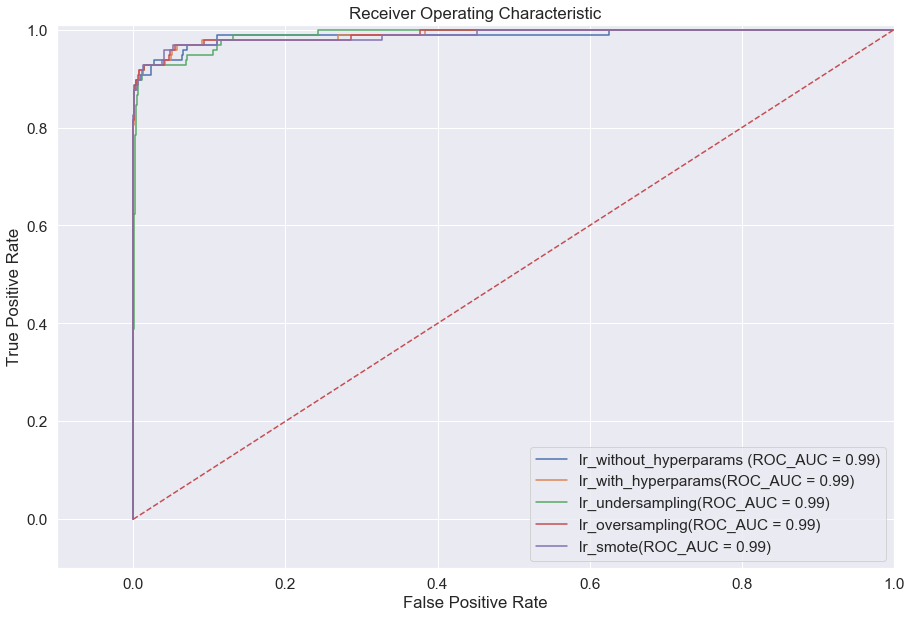

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, score_lr_wh)
fpr1, tpr1, thresholds = roc_curve(y_test, score_lr)
fpr2, tpr2, thresholds = roc_curve(y_test, score_lr_und)
fpr3, tpr3, thresholds = roc_curve(y_test, score_lr_over)
fpr4, tpr4, thresholds = roc_curve(y_test, score_lr_smote)

plt.figure(figsize=(15,10))

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

plt.plot(fpr, tpr, label='lr_without_hyperparams (ROC_AUC = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, label='lr_with_hyperparams(ROC_AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='lr_undersampling(ROC_AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='lr_oversampling(ROC_AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='lr_smote(ROC_AUC = %0.2f)' % roc_auc4)

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

В случае логистической регрессии, моделью показавшей лучшее качество является логистическая регрессия обученная на исходном наборе данных (с настроенными гиперпараметрами), а также модель обученная на данных полученных при сэмплировании миноритарного класса, которая имеет эквивалентные показатели. 

# Random Forest

### Со стандартными гиперпараметрами

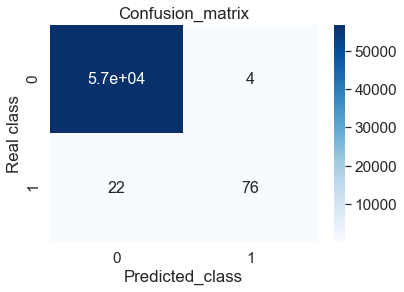

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.78      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.89      0.93     56961
weighted avg       1.00      1.00      1.00     56961



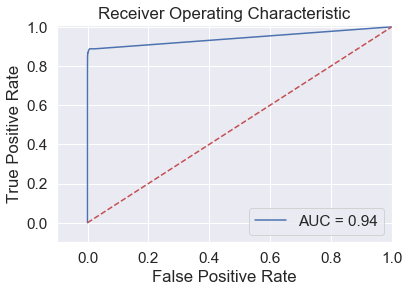

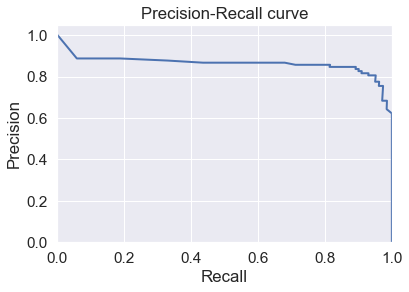

In [72]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

cm_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_plot(cm_rf)

print(classification_report(y_test, y_pred_rf))

fpr, tpr, thresholds = roc_curve(y_test, y_score_rf)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf)
pr_curve(precision, recall)

### Подбор гиперпараметров по сетке (Random Search CV) для оптимизации показателя F1

In [78]:
params_random_search = {
            'n_estimators': [100, 200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

rs = RandomizedSearchCV(rf, params_random_search, scoring='f1', cv=skf, verbose=10, n_jobs = -1)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 39.5min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 49.8min remaining: 25.6min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 54.2min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 56.9min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 61.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split...
                     

In [79]:
rs.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3}

In [80]:
rs.best_score_

0.8455153370677527

### Модель с лучшими гиперпараметрами

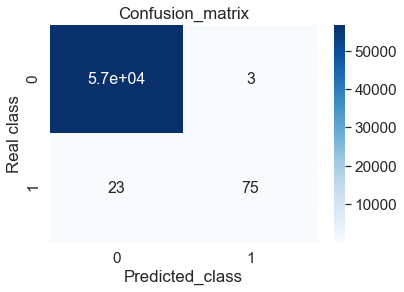

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.98      0.88      0.93     56961
weighted avg       1.00      1.00      1.00     56961



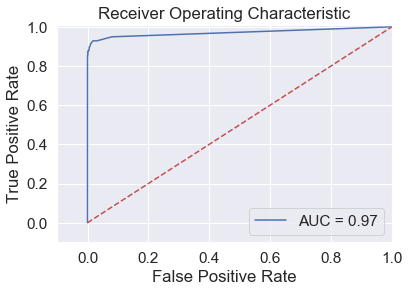

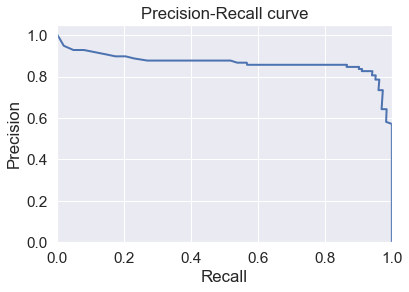

In [73]:
# rf_best = rs.best_estimator_
rf_best = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500, 
                                 min_samples_split=2, min_samples_leaf=1, max_features=3)
rf_best.fit(X_train, y_train)

y_pred_rf_best = rf_best.predict(X_test)
y_score_rf_best = rf_best.predict_proba(X_test)[:,1]

cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
conf_matrix_plot(cm_rf_best)

print(classification_report(y_test, y_pred_rf_best))

fpr, tpr, thresholds = roc_curve(y_test, y_score_rf_best)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf_best)
pr_curve(precision, recall)

Поскольку подбор гиперпараметров практически не изменил показатели precision, recall, f1-score, в дальнейшем для обучения (на больших наборах данных - в случае оверсэплинга и SMOTE) будет использоваться модель со стандартными гиперпараметрами.

### Undersampling (random forest)

In [74]:
X_train_rf_und, y_train_rf_und = undersample(X_train, y_train, 1)

1    394
0    394
Name: Class, dtype: int64


In [16]:
params_random_search = {
            'n_estimators': [100, 200, 500],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rs_und = RandomizedSearchCV(rf, params_random_search, scoring='f1', cv=skf, verbose=10, n_jobs = -1)
rs_und.fit(X_train_rf_und, y_train_rf_und)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    8.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    8.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   10.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.7s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split...
                     

In [17]:
rs_und.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3}

In [18]:
rs_und.best_score_

0.9366317069248895

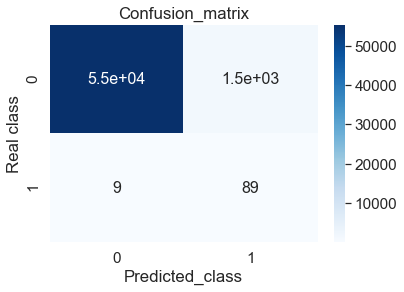

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56961
   macro avg       0.53      0.94      0.55     56961
weighted avg       1.00      0.97      0.99     56961



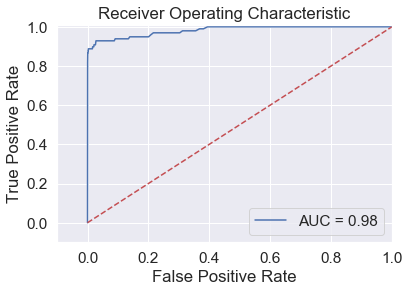

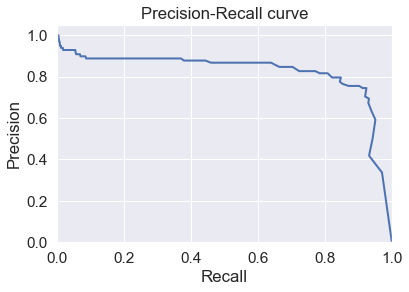

In [76]:
# rf_und_best = rs_und.best_estimator_
rf_und_best = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=200, min_samples_split=2,
                                     min_samples_leaf=1, max_features=3)
rf_und_best.fit(X_train_rf_und, y_train_rf_und)

y_pred_rf_und = rf_und_best.predict(X_test)
y_score_rf_und = rf_und_best.predict_proba(X_test)[:,1]

cm_rf_und = confusion_matrix(y_test, y_pred_rf_und)
conf_matrix_plot(cm_rf_und)

print(classification_report(y_test, y_pred_rf_und))

fpr, tpr, thresholds = roc_curve(y_test, y_score_rf_und)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf_und)
pr_curve(precision, recall)

### Oversampling (random forest)

In [59]:
X_train_rf_over, y_train_rf_over = oversample(X_train, y_train, 1)

1    227452
0    227452
Name: Class, dtype: int64


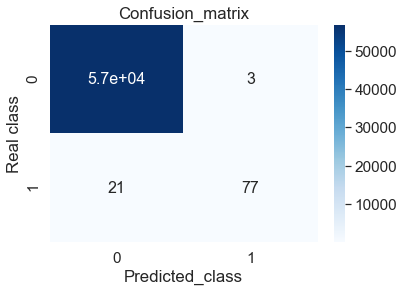

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.79      0.87        98

    accuracy                           1.00     56961
   macro avg       0.98      0.89      0.93     56961
weighted avg       1.00      1.00      1.00     56961



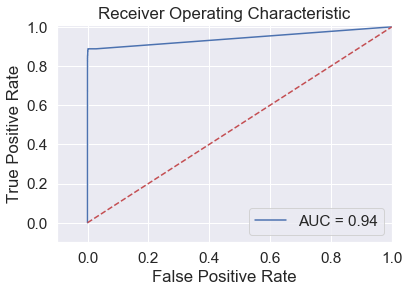

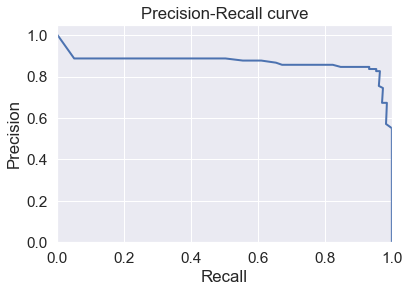

In [65]:
rf_over = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_over.fit(X_train_rf_over, y_train_rf_over)

y_pred_rf_over = rf_over.predict(X_test)
y_score_rf_over = rf_over.predict_proba(X_test)[:,1]

cm_rf_over = confusion_matrix(y_test, y_pred_rf_over)
conf_matrix_plot(cm_rf_over)

print(classification_report(y_test, y_pred_rf_over))

fpr, tpr, thresholds = roc_curve(y_test, y_score_rf_over)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf_over)
pr_curve(precision, recall)

### SMOTE (random forest)

In [66]:
smote = SMOTE(random_state=27)

X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)

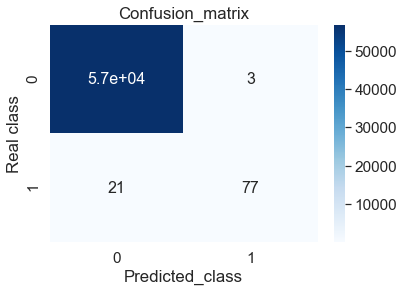

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.79      0.87        98

    accuracy                           1.00     56961
   macro avg       0.98      0.89      0.93     56961
weighted avg       1.00      1.00      1.00     56961



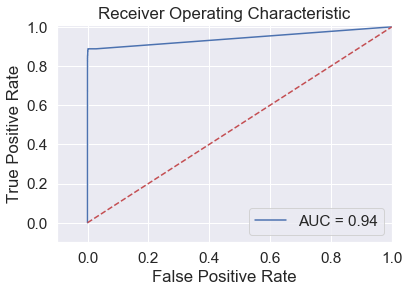

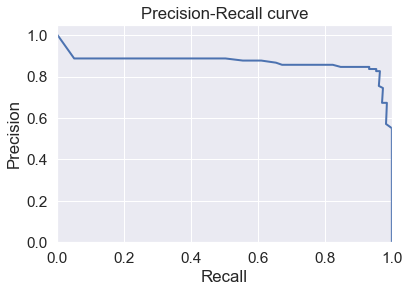

In [67]:
rf_smote = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500, 
                                 min_samples_split=2, min_samples_leaf=1, max_features=3)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_rf_smote = rf_over.predict(X_test)
y_score_rf_smote = rf_over.predict_proba(X_test)[:,1]

cm_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
conf_matrix_plot(cm_rf_smote)

print(classification_report(y_test, y_pred_rf_smote))

fpr, tpr, thresholds = roc_curve(y_test, y_score_rf_smote)
auc_roc_curve(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf_smote)
pr_curve(precision, recall)

### Сравнение PR- и ROC-кривых для моделей случайного леса

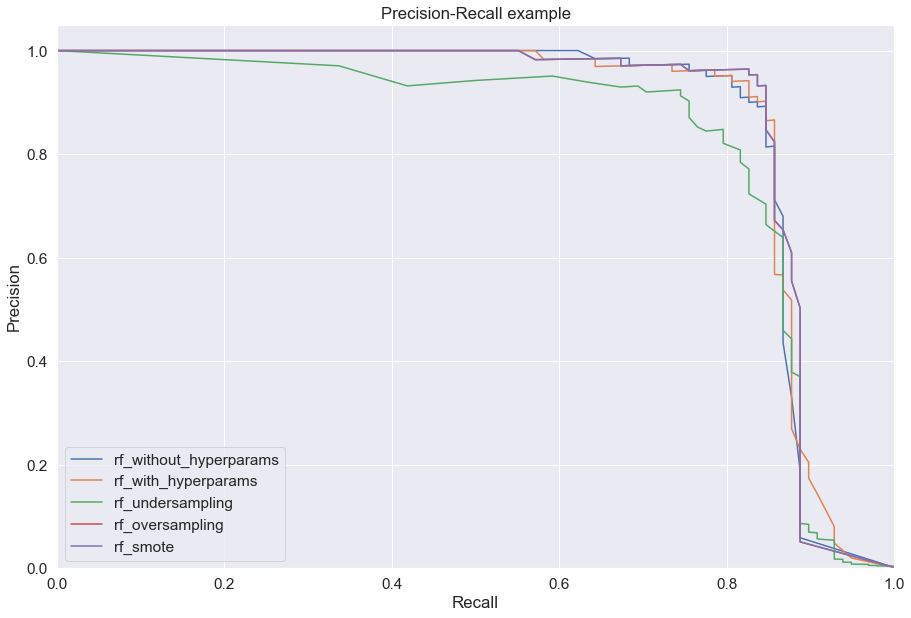

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score_rf)
precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_score_rf_best)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_score_rf_und)
precision3, recall3, thresholds3 = precision_recall_curve(y_test, y_score_rf_over)
precision4, recall4, thresholds4 = precision_recall_curve(y_test, y_score_rf_smote)

plt.figure(figsize=(15,10))

plt.plot(recall, precision, label='rf_without_hyperparams')
plt.plot(recall1, precision1, label='rf_with_hyperparams')
plt.plot(recall2, precision2, label='rf_undersampling')
plt.plot(recall3, precision3, label='rf_oversampling')
plt.plot(recall4, precision4, label='rf_smote')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example')
plt.legend(loc="lower left")

plt.show()

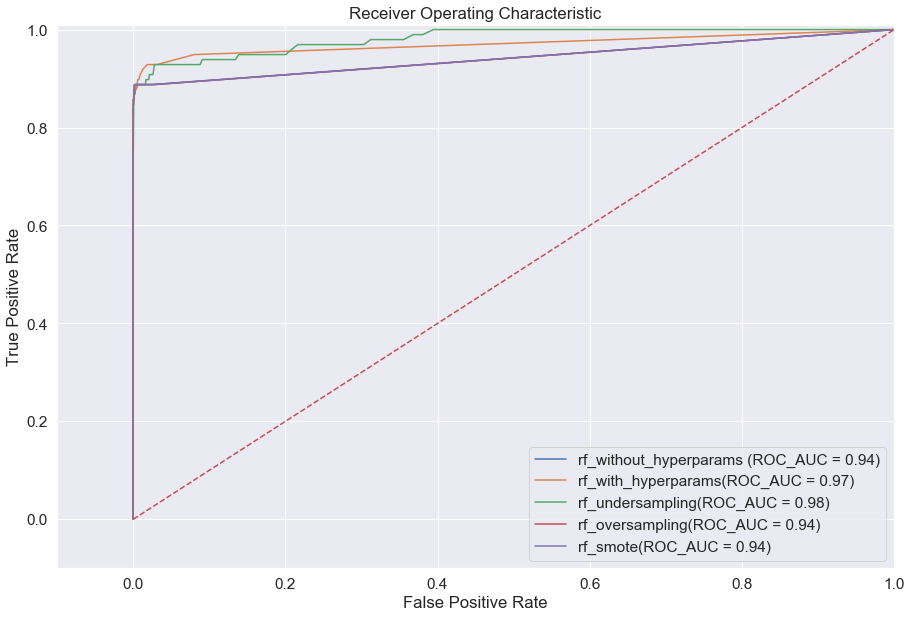

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_score_rf)
fpr1, tpr1, thresholds = roc_curve(y_test, y_score_rf_best)
fpr2, tpr2, thresholds = roc_curve(y_test, y_score_rf_und)
fpr3, tpr3, thresholds = roc_curve(y_test, y_score_rf_over)
fpr4, tpr4, thresholds = roc_curve(y_test, y_score_rf_smote)

plt.figure(figsize=(15,10))

roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

plt.plot(fpr, tpr, label='rf_without_hyperparams (ROC_AUC = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, label='rf_with_hyperparams(ROC_AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='rf_undersampling(ROC_AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='rf_oversampling(ROC_AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='rf_smote(ROC_AUC = %0.2f)' % roc_auc4)

plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

В случае случайного леса, моделью показавшей наибольший показатель Recall является алгоритм обученная на наборе данных (с настроенными гиперпараметрами), полученном при сэмплировании мажоритарного класса. 

### Сравнение показателей различных моделей

| model | precision | recall | f1-score | accuracy |
| --- | --- | --- | --- | --- | 
| lr_without_hyperparams | 0.91 | 0.54 | 0.68 | 1.0 |
| lr_with_hyperparams | 0.06 | 0.93 | 0.12 | 0.98 |
| lr_undersampling | 0.04 | 0.93 | 0.08 | 0.96 |
| lr_oversampling | 0.06 | 0.93 | 0.12 | 0.98 |
| lr_smote | 0.06 | 0.93 | 0.11 | 0.97 |
| rf_without_hyperparams | 0.95 | 0.78 | 0.85 | 1.0 |
| rf_with_hyperparams | 0.96 | 0.77 | 0.85 | 1.0 |
| rf_undersampling | 0.06 | 0.91 | 0.11 | 0.97 |
| rf_oversampling | 0.96 | 0.79 | 0.87 | 1.0 |
| rf_smote | 0.96 | 0.79 | 0.87 | 1.0 |

Поскольку наиболее важной для нас метрикой является Recall (нам хочется не упускать мошеннические транзакции), то лучшей с этой точки зрения моделью оказалась логистическая регресия, причем случай с выборкой полученной сэмплированием миноритарного (oversampling) класса и исходной несбалансированной выборкой одинаков (recall = 0.93).

Случайный лес справился с задачей немного хуже, показатель Recall заметно меньше, однако Precisin и f1-score значительно выше. Однако, в дальнейшем мы можем улучшить полученные показатели различными способами, например: произвести отбор важных признаков(feature_importances), варьировать соотношение классов (при сэмплировании, в функциях oversample и undersample - это значение "n"), также можно улучшить классификацию изменив пороговое значение для классификации к классу "1", контролируя в то же время значения показателей Recall и Precision. 